In [62]:
import seaborn
import matplotlib.pyplot as plt
import math
import os
import numpy

In [1]:
def read_bedgraph(bedgraph):
    res = []
    last = 0
    for line in open(bedgraph):
        tab = line.split()
        end = int(tab[2])
        for _ in range(last, end):
            res.append(float(tab[3]))
            last = end
    return res

In [2]:
early_R1_plus = read_bedgraph('Early-5h/S1-5h_5cov+.bedgraph')
early_R1_minus = read_bedgraph('Early-5h/S1-5h_5cov-.bedgraph')
early_R2_plus = read_bedgraph('Early-5h/S2-5h_5cov+.bedgraph')
early_R2_minus = read_bedgraph('Early-5h/S2-5h_5cov-.bedgraph')
late_R1_plus = read_bedgraph('Late-16h/S3-16h_5cov+.bedgraph')
late_R1_minus = read_bedgraph('Late-16h/S3-16h_5cov-.bedgraph')
late_R2_plus = read_bedgraph('Late-16h/S4-16h_5cov+.bedgraph')
late_R2_minus = read_bedgraph('Late-16h/S4-16h_5cov-.bedgraph')

In [20]:
def get_peaks(vector, window_size=10, min_height=10):
    peaks = []
    for i in range(len(vector) - window_size + 1):
        values = vector[i: i+window_size]
        max_value = -1; max_pos = -1
        for index,value in enumerate(values):
            if value > max_value:
                max_value = value
                max_pos = i + index        
        if max_value >= min_height:
            if peaks:
                prev_max, prev_pos = peaks[-1]
                if max_pos - prev_pos >= window_size:
                    peaks.append((max_value, max_pos))
                else:
                    if prev_max < max_value:
                        peaks.pop()
                        peaks.append((max_value, max_pos))
            else:
                peaks.append((max_value, max_pos))
    return peaks

In [21]:
## check correspondence
def check_correspondence(values1, values2, distance=10):
    if len(values1) > len(values2):
        values1, values2 = values2, values1
    matching_v2 = []
    for v2 in values2:
        for v1 in values1:
            if abs(v1[1] - v2[1]) <= distance:
                matching_v2.append(v2)
                break
    return len(matching_v2) / len(values2)

In [40]:
def read_genes(gff='Genome Info/U18466.2.gff3', out_bedfile='Genome Info/U18466.2_genes.bed'):
    genes = []
    with open(out_bedfile, 'w') as f:
        for line in open(gff):
            tab = line.split('\t')
            if len(tab) < 2:
                continue
            if tab[2] == 'gene':
                start, end, strand = int(tab[3]), int(tab[4]), tab[6]
                name = tab[8].split('Name=')[1].split(';')[0]
                genes.append((start, end, strand, name))
                print(tab[0], start-1, end-1, name, '.', tab[6], sep='\t', file=f)
    return genes

genes = read_genes()       

In [59]:
## get subset of genes with mapped start sites
def get_genes_starts(genes, peaks):
    tmp_start = 'tmp_tss.bed'
    with open(tmp_start, 'w') as f:
        peaks.sort(key=lambda x: x[0])
        for start, strand, value in peaks:
            print('U18466.2', start-1, start, '.', value, strand, sep='\t', file=f)
    cmd = 'bedtools closest -s -D a -io -iu -a "%s" -b "%s" > tmp' % (tmp_start, 'Genome Info/U18466.2_genes.bed')
    os.system(cmd)
    gene2tss = {}
    for line in open('tmp'):
        tab = line.split()
        if tab[9] not in gene2tss:
            gene2tss[tab[9]] = []
        gene2tss[tab[9]].append((int(tab[2]), float(tab[4])))
    return gene2tss

def sum_peaks(peaks_plus, peaks_minus):
    peaks_total = []
    for p in peaks_plus:
        peaks_total.append((p[1], '+', p[0]))
    for p in peaks_minus:
        peaks_total.append((p[1], '-', p[0]))
    return peaks_total 

In [88]:
## get max from a window
for min_height in [5,10,20,30]:
    for window_size in [3,5,10]:
        peaks = {}
        gene2tss = {}
        
        peaks['early R1 plus'] = get_peaks(early_R1_plus, window_size, min_height)
        peaks['early R1 minus'] = get_peaks(early_R1_minus, window_size, min_height)
        gene2tss['early R1'] = get_genes_starts(genes, sum_peaks(peaks['early R1 plus'], peaks['early R1 minus']))
        
        peaks['early R2 plus'] = get_peaks(early_R2_plus, window_size, min_height)
        peaks['early R2 minus'] = get_peaks(early_R2_minus, window_size, min_height)
        gene2tss['early R2'] = get_genes_starts(genes, sum_peaks(peaks['early R2 plus'], peaks['early R2 minus']))

        peaks['late R1 plus'] = get_peaks(late_R1_plus, window_size, min_height)
        peaks['late R1 minus'] = get_peaks(late_R1_minus, window_size, min_height)
        gene2tss['late R1'] = get_genes_starts(genes, sum_peaks(peaks['late R1 plus'], peaks['late R1 minus']))
 
        peaks['late R2 plus'] = get_peaks(late_R2_plus, window_size, min_height)
        peaks['late R2 minus'] = get_peaks(late_R2_minus, window_size, min_height)
        gene2tss['late R2'] = get_genes_starts(genes, sum_peaks(peaks['late R2 plus'], peaks['late R2 minus']))

        print('min height:', min_height, '& window size:', window_size)
        all_genes = set(); late_genes = set(); early_genes = set(); ntss = []; early_genes_ntss = []
        for k in gene2tss:
            all_genes.update(set(gene2tss[k].keys()))
            if 'late' in k:
                late_genes.update(set(gene2tss[k].keys()))
            elif 'early' in k:
                early_genes.update(set(gene2tss[k].keys()))
                early_genes_ntss += [len(gene2tss[k][x]) for x in gene2tss[k]]
            ntss += [len(gene2tss[k][x]) for x in gene2tss[k]]

        print('n genes mapped in all replicates: %d (early: %d, late: %d)' % (len(all_genes), 
                                                                              len(early_genes), len(late_genes)))
        print('median number of TSSs mapped: %d (early: %d)' % (numpy.median(ntss), 
                                                                   numpy.median(early_genes_ntss)))
        correspondeces = [check_correspondence(peaks['early R1 plus'], peaks['early R2 plus']),
                          check_correspondence(peaks['early R1 minus'], peaks['early R2 minus']),
                          check_correspondence(peaks['late R1 plus'], peaks['late R2 plus']),
                          check_correspondence(peaks['late R1 minus'], peaks['late R2 minus'])
                         ]
        print('minimum correspondence between replicates: %.2f' % min(correspondeces))  
        print()


min height: 5 & window size: 3
n genes mapped in all replicates: 153 (early: 129, late: 153)
median number of TSSs mapped: 12 (early: 2)
minimum correspondence between replicates: 0.81

min height: 5 & window size: 5
n genes mapped in all replicates: 153 (early: 128, late: 153)
median number of TSSs mapped: 10 (early: 2)
minimum correspondence between replicates: 0.77

min height: 5 & window size: 10
n genes mapped in all replicates: 153 (early: 128, late: 153)
median number of TSSs mapped: 8 (early: 2)
minimum correspondence between replicates: 0.75

min height: 10 & window size: 3
n genes mapped in all replicates: 152 (early: 108, late: 152)
median number of TSSs mapped: 8 (early: 2)
minimum correspondence between replicates: 0.82

min height: 10 & window size: 5
n genes mapped in all replicates: 152 (early: 108, late: 152)
median number of TSSs mapped: 7 (early: 1)
minimum correspondence between replicates: 0.79

min height: 10 & window size: 10
n genes mapped in all replicates: 152

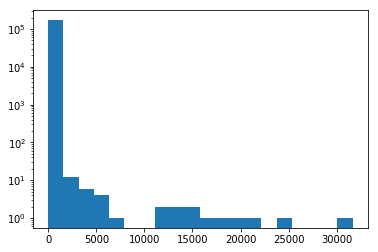

In [28]:
fig, ax = plt.subplots()
ax.hist(early_R2, 50)
ax.set_yscale('log')